# PHYS20762 - Project  3 - Particle Transport
student ID: 10485506 <br>
University of Manchester <br>
May 2021

We first initialise Python interpreter.

In [1]:
# Initialisation
import numpy as np
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')
plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Project Outline

This project aims to investigate particle transport, specifically, penetration of neutrons through the materials of different thickness and composition. Transmission, absorption and reflection rated are calculated for three types of materials: water, lead, and graphite.

The procedure includes simulating a path of a neutron through the material, assuming collisions with material particles with two possible outcomes: scattering or absorption, both having constant probabilities throughout the neutron's journey.

##  1. Random Number Generators

### 1.1 Uniform random numbers

For the project, we need random numbers to simulate events which are random in nature. First, we need to make sure that our generated numbers are uniform i.e. each number has an equal probability of being generated. This is required to eliminate any biases and systematic errors from the simulation. For this purpose, an inbuilt numpy random generator is used, which generates an array of given size consisting of random numbers from 0 to 1 if otherwise not specified.

To check how well this generator performs, an array of sufficient size is generated and binned data is plotted to see if a probability density function (PDF) is uniform.

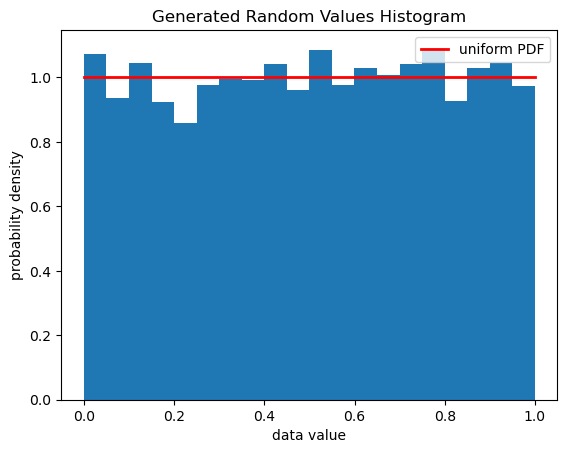

In [2]:
# generate ramdom array of numbers
random_array = np.random.uniform(size=5000)

# plot them as a histogram
count, bins, ignored = plt.hist(random_array, 20, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r', label='uniform PDF')

# fix labels
plt.xlabel('data value')
plt.ylabel('probability density')
plt.title('Generated Random Values Histogram')
plt.legend()
plt.show()

It can be seen that data fluctuates about the uniformly distributed function. Red line indicates the perfect uniform probability density function. It is not perfect, which suggests that there is an inherent statistical error to such procedure when one has a finite number of samples. The percentage error, however, is decreasing with the sample number, so with a sufficient number of samples a desired accuracy can be reached.

### 1.2 3-dimentional uniform distribution

Same function can be used to generate point in any number of dimensions. The uniformity of such random array in 3D can be checked visually by plotting all data as points in 3D space.

In [6]:
# generate an array of 3D random points
array3D = np.random.uniform(size=(3, 1000))

# make a plot

# import 3D axes, make the plot interactive
from mpl_toolkits.mplot3d import Axes3D
get_ipython().magic('matplotlib notebook')
plt.rcParams.update({'font.size': 14})
plt.style.use('default')

# create a figure
fig = plt.figure(num='Generated Random Values Scatter Plot')
ax = Axes3D(fig)
ax.scatter(array3D[0, :], array3D[1, :], array3D[2, :], color='r')

# fix labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

<IPython.core.display.Javascript object>

Judging by eye, all data points are uniformly distributed form any point of view indeed.

The other uniform number distribution can be obtained by Linear congruential generator. It is created by the
recurrence relation <br>

$X_{n+1} = (aX_n + c)$ mod $m$, where 

$ 0 < m $<br>
$ 0 < a < m $<br>
$ 0 ≤ c < m $<br>
$ 0 ≤ X_0 < m $<br>

In [7]:
import numpy as np
 
#  RANDSSP Multiplicative congruential uniform random number generator.
#  Based on the parameters used by IBM's Scientific Subroutine Package.
#  The statement
#  r = randssp(m,n)
#  generates an m-by-n random matrix.
#  The function can not accept any other starting seed.
#
#  This function uses the "bad" generator parameters that IBM
#  used in several libraries in the 1960's.  There is a strong
#  serial correlation between three consecutive values.

def randssp(p,q):
    
    global mm, aa, cc, xx
        
    try: xx
    except NameError:
        mm = pow(2, 31)
        aa = pow(2, 16) + 3
        cc = 0
        xx = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            xx = np.mod(aa*xx + cc, mm)
            r[k, l] = xx/mm
    
    return r

However, if one is not careful enough with the choice of parameters, a problem might occur. Turns out that generated numbers are not quite randomly distributed, but rather lie on so called hyperplanes. This introduces undesired correlation between the points, so this method is not used in a further simulation. 

This correlation can be shown using a scatter plot in a 3D space.

In [8]:
# generate an array of 3D points 
points = randssp(3, 1500)

# make the plot interactive
get_ipython().magic('matplotlib notebook')

# create a figure
fig = plt.figure('(Not So) Randomly Generated Points')
ax = Axes3D(fig)
ax.scatter(points[0, :], points[1, :], points[2, :], color='r')

# fix labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

<IPython.core.display.Javascript object>

It can be seen that data is not completely uniformly distributed, but only from the specific angle. Below, two snapshots of the same plot are given to illustrate this point.

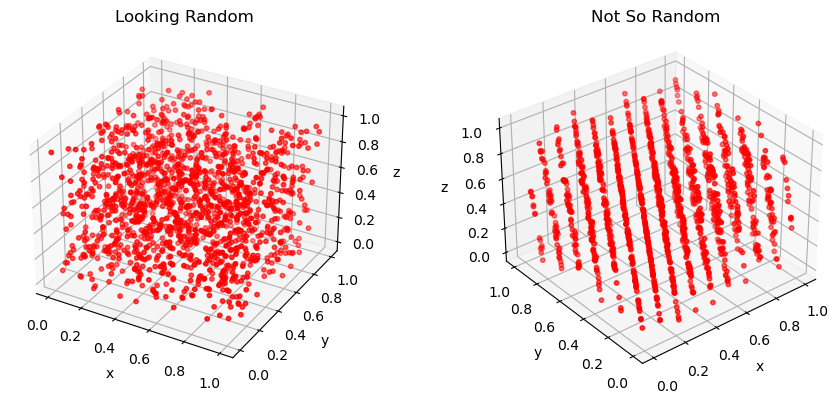

In [9]:
# make the plot static
get_ipython().magic('matplotlib inline')
plt.rcParams.update({'font.size': 14})
plt.style.use('default')


# create a figure
fig = plt.figure(figsize=(10, 4))

# first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(points[0, :], points[1, :], points[2, :], color='r', s=10)

# fix labels
ax.set_title('Looking Random')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# create second plot
ax = fig.add_subplot(1, 2, 2, azim=-129, elev=32, projection='3d')
ax.scatter(points[0, :], points[1, :], points[2, :], color='r', s=10)

# fix labels
ax.set_title('Not So Random')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.tight_layout()
plt.show()

### 1.3 Non-uniform random samples

For our future purposes we need to generate random numbers, which follow exponential distribution rather than a uniform one. It should have the form of $y(x) = e^{-\frac{x}{\lambda}}$. 

To achieve this, the cumulative probability function will be used.

Cumulative probability function (CDF) is obtained by integrating the desired probability density function (PDF) up to a specific point. For exponential decay, it is done as follows

$cdf(x) = \int_{ 0 }^{x} e^{-x} .dx = 1 - e^{-x}$ which has a value between 0 and 1 (as it is a probability). An inverse CDF can be found then<br>
$cdf^{-1}(x) = -ln(1 - x)$, which allows us to assign the exponentially distributed value of x with the generated random number from 1 to 0.

Including a mean free path scaling factor $\lambda$, we get <br>

$ x = - \lambda ln(u)$, where $x$ is the exponentially distributed data value and $u$ is given by the uniform random distribution.  


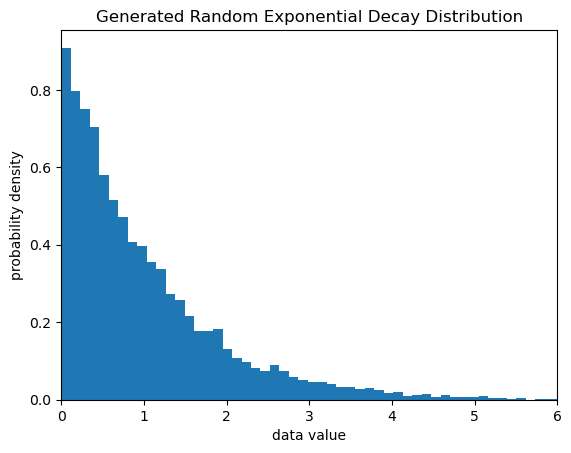

In [10]:
# define the function
def InverseCDF(u, l):
    return -l * np.log(u)

# generate a random sample
random_array = np.random.uniform(size=10000)

# find a corresponding exponential sample with lambda = 1
x = InverseCDF(random_array, 1)

# create a justifying histogram
count, bins, ignored = plt.hist(x, 100, density=True)
plt.xlim(0, 6)
plt.xlabel('data value')
plt.ylabel('probability density')
plt.title('Generated Random Exponential Decay Distribution')
plt.show()

The plot verifies that the resulting distribution is indeed exponentially decaying. It is checked more carefully in the following sections.

## 2. Application for neutron absorbtion

Now we apply this model to the specific case of attenuation (ignoring scattering). 

The number of absorbed neutrons can be expressed as $N_L = n\sigma IL$, <br>

where: <br>
$n$ - number of absorbing nuclei <br>
$\sigma$ - absorption cross-section of the target material<br>
$I$ - neutron intensity<br>
$L$ - thickness of the absorption material layer<br>

The number of absorbing nuclei is given by $n = \frac {\rho N_A}{M}$, <br>

where: <br>
$\rho$ - density of the material<br>
$N_A$ - Avogadro's number<br>
$M$ - molar mass of the material<br>

from this, the rate of absorption can be found:<br>
$-\frac{dI}{dx} = n\sigma I$.

And finally, the differential equation can be solved to get an expression of neutron intensity as a function of distance travelled in material x: <br>
$I(x) = e^{-n\sigma x} = e^{- \frac{x}{\lambda}}$, where $\lambda$ is the mean free path of neutrons in the material. This equation obeys exponential distribution derived in previous section.

In this section, we investigate statistical errors on mean free path given by this model for absorption of neutrons in water.

In [11]:
# paremeters for water

x_section_abs = 0.6652e-24 #cm^2
density = 1.00 #g/cm^3

N_A = 6.0221409e+23
M = 18.01528 #g/mol

# mean free path (lambda is exchanged for l)
l = 1 / (density * N_A * x_section_abs / M)

print('mean free path of neutrons in water is {:.3f} cm'.format(l))

mean free path of neutrons in water is 44.972 cm


### 2.1 Absorption mean free path

To estimate the value of mean free path in water and the corresponding error, an array of exponentially distributed numbers is generated repeatedly. A number of repeats is sufficient for statistical parameters such as mean or standard deviation to be reliable. Then data is split into fixed bins and for each bin, mean and standard deviation of count number are calculated. This data is then linearised and a straight line is fitted to it. 

Corresponding gradient parameter is related to the mean free path $m = -\frac{ 1}{\lambda}$<br>
Propagated error is then $\sigma_{\lambda} = \frac{\lambda}{m} \sigma_{m} = \frac{\sigma_{m}}{m^2} $.

In [12]:
# create an empty array for counts
counts_array = np.empty((0, 50))

# generate the distribution using random numbers 100 times
for i in range(100):

    random_array = np.random.uniform(size=10000)
    I = InverseCDF(random_array, l)
    
    # bin data
    counts, edges = np.histogram(I, bins=50, range=(0,400))
    edges = edges[:-1]
    
    # append to the total data set
    counts_array = np.vstack((counts_array, counts))

# calculate means and standard deviations for each bin
count_means = np.mean(counts_array, axis=0)
count_std = np.std(counts_array, axis=0)

# make a fit
counts_fit = count_means[np.where(count_means != 0)]
edges_fit = edges[np.where(count_means != 0)]
count_std_fit = count_std[np.where(count_means != 0)]
coeffs = np.polyfit(edges_fit, np.log(counts_fit), 1, w=counts_fit/count_std_fit, cov=True)

Plot results and show an estimate value of the mean free path.

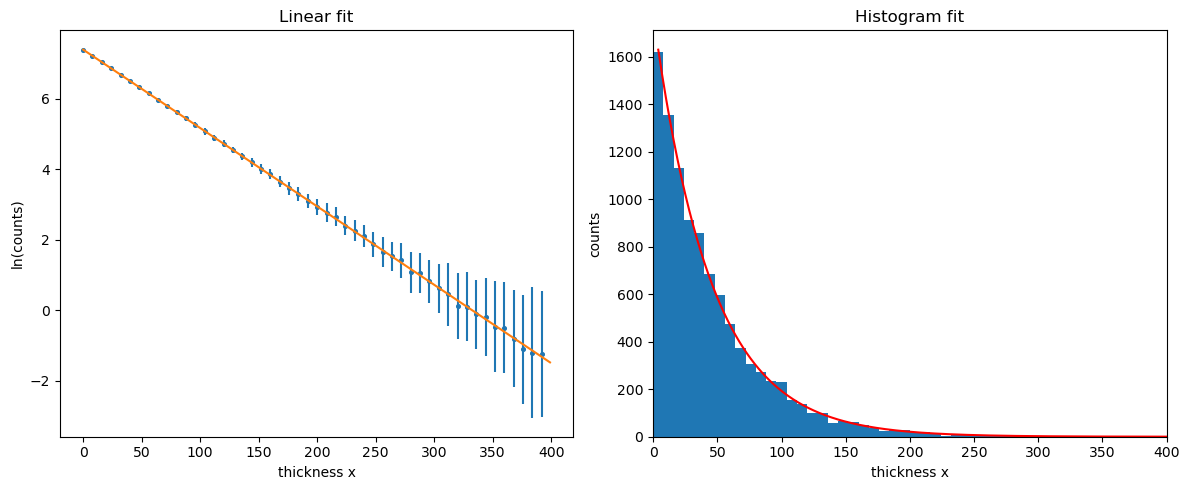

In [13]:
# create a figure
fig = plt.figure(figsize=(12, 5))

# first plot
ax1 = fig.add_subplot(121)
ax1.errorbar(edges_fit, np.log(counts_fit), count_std_fit/counts_fit, ls='None')
ax1.scatter(edges_fit, np.log(counts_fit), s=7)
x = np.arange(0, 400, 1)
ax1.plot(x, coeffs[0][0] * x + coeffs[0][1])

# fix labels
ax1.set_title('Linear fit')
ax1.set_xlabel('thickness x')
ax1.set_ylabel('ln(counts)')

# create second plot
ax2 = fig.add_subplot(122)
ax2.hist(I, bins=50, range=(0,400))
ax2.set_xlim(0, 400)
ax2.plot(x + 0.5*(edges[1] - edges[0]), np.exp(coeffs[0][1] + x * coeffs[0][0]), color='r')

# fix labels
ax2.set_title('Histogram fit')
ax2.set_xlabel('thickness x')
ax2.set_ylabel('counts')

plt.tight_layout()
plt.show()

In [14]:
print('estimated mean free path of neutrons in water is {:.3f} ± {:.1} cm'
      .format(- 1 / coeffs[0][0], coeffs[1][0][0] / coeffs[0][0]**2))

estimated mean free path of neutrons in water is 44.978 ± 1e-06 cm


It can be seen that the fit was successful in predicting the value of mean free path. However, estimated uncertainty is clearly underestimated, and the real error is more likely to be in order of 1 mm. 

Chosen sample number (constrained by the computational time) might not be sufficient for standard deviation to be a reliable estimate of error on data points. Such individual errors are likely to be overestimated for covariance matrix given by the fit to represent the error on the mean free path.

### 2. 2 Generating random direction

In the following simulation, neutrons are required to move in a 3D space. A neutron must have equal probability to go in any direction when scattered form the material particles as it is a random process. Therefore, a random generator for uniformly distributed directions is created, by picking two angles. It can be tested using standard spherical coordinates used in physics ($\theta$ being polar angle and $\phi$ being azimuthal angle) by generating a number of points, with the same distance from the origin and direction chosen randomly. This creates a sphere of uniformly distributed points if working correctly.

Polar angle ($\theta$) introduces some non-uniformity with more points on the poles of the sphere if generated simply by multiplying random number and π. To avoid this, $\theta$ is generated using the following relation,

$\theta = arccos(1 - 2u)$, where $u$ is a random number between 0 and 1.

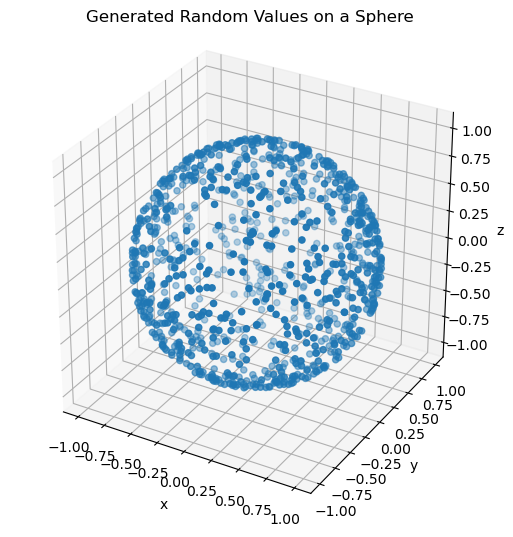

In [15]:
# generate phi and theta
phi = 2*np.pi*np.random.uniform(size=1000)
theta = np.arccos(1 - 2*np.random.uniform(size=1000))
r = 1

# use spherical coordinates formulae
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# create a plot
fig = plt.figure()
ax = Axes3D(fig)
ax.set_box_aspect((1, 1, 1))
ax.scatter(x, y, z)

# fix the labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Generated Random Values on a Sphere')

plt.show()

It can be seen that the generator works successfully as points are distributed uniformly on the surface of the sphere.

## 3. Main simulation

First, a function for making a random step in the material with mean_free path $\lambda$ is created.

Step has a randomly chosen length, the probability of which follows exponential distribution $e^{- \frac{x}{\lambda}}$. Direction is chosen randomly and uniformly as described in previous section.

In [16]:
# lambda variable is exchanged for l
def RandomStep(l):
    """
    Chooses a random step in the specific material characterised by the mean free path l.
    """
    
    # pick step length randomly
    r = InverseCDF(np.random.uniform(), l)
    
    # generate phi and theta
    phi = 2*np.pi*np.random.uniform()
    theta = np.arccos(1 - 2*np.random.uniform())
    
    # use spherical coordinates formulae
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    
    return np.array([x, y, z])

### 3.1 Scattering

Attenuation parameters are calculated for three materials: water lead and graphite. Now, scattering is considered as well. To calculate mean free path, we combine scattering and absorption cross-sections as follows,

$\lambda = \frac{1}{\Sigma_a + \Sigma_s}$, where $\Sigma_a = n\sigma_a$  and $\Sigma_s = n\sigma_s$ are called macroscopic absorption cross-sections for absorption and scattering, respectively.

The probability of a particular process after the step is completed, is given by:<br>

$P_a = \frac{\Sigma_a}{\Sigma_a + \Sigma_s}$ for absorption, or <br>

$P_s = \frac{\Sigma_s}{\Sigma_a + \Sigma_s}$ for scattering.


In [17]:
# data
# general
N_A = 6.0221409e+23

names = np.array(['water', 'lead', 'graphite'])

# other parematers for [water, lead, graphite]
M = np.array([18.01528, 455.24, 12.011]) #g/mol
x_section_absorb = np.array([0.6652e-24, 0.158e-24, 0.0045e-24]) #cm^2
x_section_scatter = np.array([103.0e-24, 11.221e-24, 4.74e-24]) #cm^2
density = np.array([1.00, 11.35, 1.67]) #g/cm^2

# macroscopic cross-sections
macro_x_section_absorb = (density * N_A * x_section_absorb / M)
macro_x_section_scatter = (density * N_A * x_section_scatter / M)

# macroscopic mean free path calculation
mean_free_path = 1 / (macro_x_section_absorb + macro_x_section_scatter) #cm

# absorbtion probability calculation
absorbtion_probability_array = macro_x_section_absorb / (macro_x_section_absorb + macro_x_section_scatter)

### 3.2 Path simulation

We finally can attempt to simulate the path of a neutron through the material with particular attenuation parameters.

In [19]:
def PathRun(l, absorbtion_probability, T=10., track_position=True):
    """
    Simulates the path of a neutron in the finite slab of material, considering scattering and absorbtion.
    Outputs the path hystory of the neurton together with the information whether it's been 
    reflected, absorbed or transmitted.
    
    Parameters
    ----------
    l - mean free path in the material for both scattering and absorbtion combined (float)
    absorbtion_probability - the probability that the neutron gets absorbed in the end of each step (float)
    T - thickness of the material (float, default: 10)
    track_position - whether to output the path hystory of the neurton (bool, default: True)
    
    Returns
    ---------
    position_history - the path hystory of the neurton (float array)
    absorbed - 1 if the neurton was absorbed, 0 if not (int)
    reflected - 1 if the neurton was reflected, 0 if not (int)
    transmitted - 1 if the neurton was transmitted, 0 if not (int)
    """

    # Initialisation 
    is_absorbed = False
    position = np.array([0., 0., 0.])

    # neutron counters
    absorbed = 0
    reflected = 0
    transmitted = 0

    # history tracker
    position_history = np.array([0., 0., 0.])

    while not is_absorbed:

        # initial step is made in +x direction
        if position[0] == 0:
            position[0] = InverseCDF(np.random.uniform(), l)

        # make a step
        else:
            position = position + RandomStep(l)
        
        if track_position:
            position_history = np.vstack((position_history, position))

        # left slab?
        if position[0] < 0:
            is_outside = 1
            reflected += 1
            break
        elif position[0] > T:
            is_outside = 1
            transmitted += 1
            break

        # choose process
        choice = np.random.uniform()

        if choice < absorbtion_probability:
            # particle is absorbed
            absorbed += 1
            is_absorbed = True
            
    return position_history, absorbed, reflected, transmitted

Let's try it out for 10 neutrons in each material.

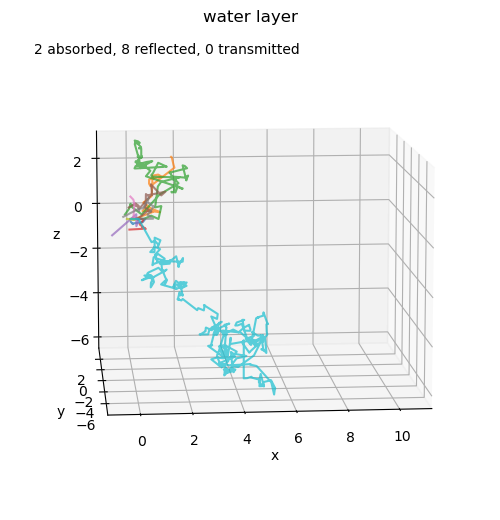

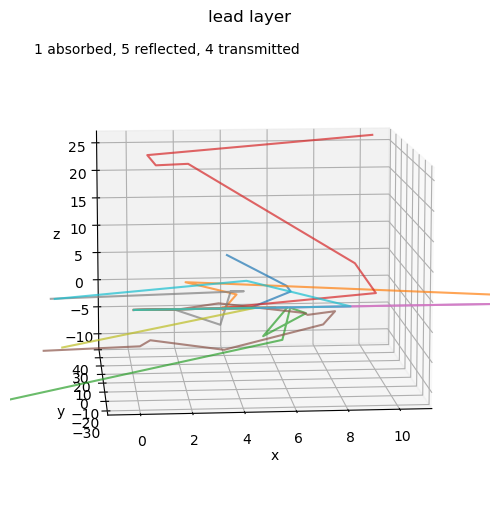

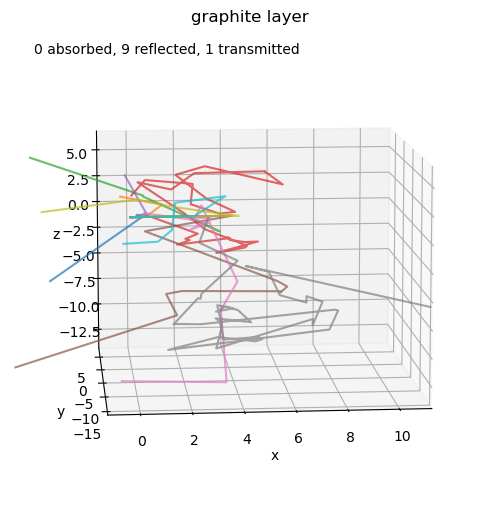

In [20]:
# run through three different materials
for (Lambda, absorb_probability, name) in zip(mean_free_path, absorbtion_probability_array, names):
    
    # history counters
    absorbed_total = 0
    reflected_total = 0
    transmitted_total = 0

    # create a figure
    fig = plt.figure()
    ax = Axes3D(fig, azim=90 + 175, elev=10)
    
    # for 10 neutrons
    for i in range(10):
        
        # run the silulation
        position_history, absorbed, reflected, transmitted = PathRun(Lambda, absorb_probability)
        
        # update counters
        absorbed_total += absorbed
        reflected_total += reflected
        transmitted_total += transmitted
        
        # create a plot for the path 
        ax.axes.set_xlim3d(left=-1, right=11)
        ax.plot(position_history[:, 0], position_history[:, 1], position_history[:, 2], alpha=0.7)
        
        
    # display counters
    ax.text2D(0.05, 0.95, "{} absorbed, {} reflected, {} transmitted".format(absorbed_total, 
                                                                             reflected_total, 
                                                                             transmitted_total), 
              transform=ax.transAxes)    
    
    # fix the labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('{} layer'.format(name))
    plt.show()

### 3.3 Absorption, reflection and transmission probabilities for 10cm slab of three materials

Now we make much more simulation runs, not plotting the output but instead counting the fraction of absorbed, scattered and transmitted neutrons.

In [21]:
def Results(runs_number, Lambda, absorb_probability, layer_thickness=10, only_transmit=False):
    """
    Calculates how many of the simulated neutrons has been reflected, transmitted and absorbed.
    Outputs the corresponding reflection, absorbtion and transmission probabilities.
    
    Parameters
    ----------
    runs_number - number of simulated neutrons (int)
    Lambda - mean free path in the material for both scattering and absorbtion combined (float)
    absorb_probability - the probability that the neutron gets absorbed in the end of each step (float)
    layer_thickness - thickness of the material (float, default: 10)
    only_transmit - an option to only count transmitted neutrons to decrease computational time
    (bool, default: False)
    
    Returns
    ---------
    probabilities - absorbtion, reflection and transmission probabilities (float array)
    transmission_probability - if only transmission probability required (float)
    """

    if only_transmit:
        
        transmitted_total = 0
        for i in range(runs_number):

            position_history, absorbed, reflected, transmitted = PathRun(Lambda, 
                                                                         absorb_probability, 
                                                                         T=layer_thickness)
            transmitted_total += transmitted

        transmission_probability = transmitted_total / runs_number

        return transmission_probability
    
    else:
        
        absorbed_total = 0
        reflected_total = 0
        transmitted_total = 0

        for i in range(runs_number):

            position_history, absorbed, reflected, transmitted = PathRun(Lambda, 
                                                                         absorb_probability, 
                                                                         T=layer_thickness, 
                                                                         track_position=False)
            absorbed_total += absorbed
            reflected_total += reflected
            transmitted_total += transmitted

        absorbtion_probability = absorbed_total / runs_number
        reflection_probability = reflected_total / runs_number
        transmission_probability = transmitted_total / runs_number
        probabilities = np.array([absorbtion_probability, reflection_probability, transmission_probability])

        return probabilities

To get desired probabilities together with respective errors, a sample of chosen number of neutrons is simulated several times. Mean and standard deviation is given. Additionally, in brackets, the error given propagated from the Binomial (approaching Gaussian) distribution ($ counts ± \sqrt{counts} $) which is $\sigma_p = \frac{\sqrt{counts}}{N}$, where N is the total number of neutrons.

In the following piece of code, one can choose some important parameters of simulation.


In [22]:
neutron_number = input("Enter how many neutrons to simulate: ")
run_number = input("Enter how many runs to complete: ")
material_thickness = 10

made_decision = False

while not made_decision:
    decision = input("Do you want to change the default material thickness (10cm)? Please enter yes or no: ")

    if decision.lower() == 'yes':
        material_thickness = input('Enter your material thickness in cm: ')
        made_decision = True
        
    elif decision.lower() == 'no':
        made_decision = True
        
    else:
        print('Not a valid answer. Plsease start again.')        
        
print(' ')
print('Main Parameters:')
print('-----------------------------')
print('Thickness of material = {} cm'.format(material_thickness))
print('Number of neutrons = {}'.format(neutron_number))
print('Number of runs = {}'.format(run_number))
print('-----------------------------')
print(' ')

for (Lambda, absorb_probability, name) in zip(mean_free_path, absorbtion_probability_array, names):

    data_array = np.empty((0, 3))
    error_array = np.empty((0, 3))

    for i in range(int(run_number)):
        
        data = Results(int(neutron_number), Lambda, absorb_probability, 
                       layer_thickness=np.float(material_thickness))
        errors = np.sqrt(data) / int(neutron_number)
        
        data_array = np.vstack((data_array, data))
        error_array = np.vstack((error_array, errors))
    
    means = np.mean(data_array, axis=0)
    std = np.std(data_array, axis=0)
    estimated_error = np.mean(error_array, axis=0)
    
    print('For {}'.format(name))
    print('~~~~~~~~~~~~~~~~~~~~')
    print('Absorbtion probability = {:.5f} ± {:.5f} (± {:.5f}) %'.format(means[0] * 100, 
                                                                       std[0] * 100, 
                                                                       estimated_error[0] * 100))
    print('Reflection probability = {:.5f} ± {:.5f} (± {:.5f}) %'.format(means[1] * 100, 
                                                                       std[1] * 100, 
                                                                       estimated_error[1] * 100))
    print('Transmission probability = {:.5f} ± {:.5f} (± {:.5f}) %'.format(means[2] * 100, 
                                                                         std[2] * 100, 
                                                                         estimated_error[2] * 100))
    print(' ')

Enter how many neutrons to simulate: 1000
Enter how many runs to complete: 10
Do you want to change the default material thickness (10cm)? Please enter yes or no: no
 
Main Parameters:
-----------------------------
Thickness of material = 10 cm
Number of neutrons = 1000
Number of runs = 10
-----------------------------
 
For water
~~~~~~~~~~~~~~~~~~~~
Absorbtion probability = 20.61000 ± 1.91073 (± 0.04535) %
Reflection probability = 79.13000 ± 1.89739 (± 0.08895) %
Transmission probability = 0.26000 ± 0.14283 (± 0.00473) %
 
For lead
~~~~~~~~~~~~~~~~~~~~
Absorbtion probability = 4.20000 ± 0.32863 (± 0.02048) %
Reflection probability = 45.39000 ± 1.35606 (± 0.06736) %
Transmission probability = 50.41000 ± 1.46659 (± 0.07099) %
 
For graphite
~~~~~~~~~~~~~~~~~~~~
Absorbtion probability = 0.81000 ± 0.26249 (± 0.00885) %
Reflection probability = 68.76000 ± 1.74310 (± 0.08291) %
Transmission probability = 30.43000 ± 1.58874 (± 0.05515) %
 


Regardless of one's choise, here are some of the results for previous runs of the simulation:

For the fixed parameters of 10 cm slab and 10 runs of simulation:

#### 1000 neutrons

**Water**

> Absorbtion probability = 20 ± 1 (± 0.05) %<br>
Reflection probability = 79 ± 1 (± 0.09) %<br>
Transmission probability = 0.3 ± 0.1 (± 0.01) %<br>
 
**Lead**

> Absorbtion probability = 4.3 ± 0.5 (± 0.02) %<br>
Reflection probability = 45 ± 1 (± 0.1) %<br>
Transmission probability = 50 ± 1 (± 0.1) %<br>
 
**Graphite**

> Absorbtion probability = 0.7 ± 0.2 (± 0.01) %<br>
Reflection probability = 68± 2 (± 0.08) %<br>
Transmission probability = 31 ± 1 (± 0.1) %<br>

#### 10000 neutrons

**Water**

> Absorbtion probability = 20.2 ± 0.3 (± 0.004) %<br>
Reflection probability = 79.5 ± 0.3 (± 0.01) %<br>
Transmission probability = 0.33 ± 0.05 (± 0.001) %<br>
 
**Lead**

> Absorbtion probability = 4.2 ± 0.1 (± 0.002) %<br>
Reflection probability = 45.1 ± 0.4 (± 0.01) %<br>
Transmission probability = 50.7 ± 0.5 (± 0.01) %<br>
 
**Graphite**

> Absorbtion probability = 0.9 ± 0.1 (± 0.001) %<br>
Reflection probability = 68.5 ± 0.6 (± 0.01) %<br>
Transmission probability = 30.6 ± 0.5 (± 0.01) %<br>

Water has much lower transmission rate than lead and graphite, so it is the best material for neutron attenuation. Exceptionally high scattering cross-section of water is represented in the high result for reflection probability. Graphite has the lowest absorption rate, however it scatters neutrons away better than lead, which makes it second best candidate for shielding.

It can be seen that both estimated errors decrease as more neutrons are simulated as expected. However, the estimated error for Binomial distribution is about one order of magnitude smaller than the statistical error calculated. One can think it might be caused by the insufficient number of simulation runs. However, when simulation was completed for 100 runs, estimated uncertainties did not change significantly. This suggests that either the increase in the number of runs was not significant enough or that the way of estimating the error is wrong. Statistical error seems to be more reliable for this case and so is first to be quoted.


## 4. Variation with thickness

### 4.1 Plots

Representative plots are created to represent the variation of absorption, transmission and reflection probabilities with slab thickness for all three materials.

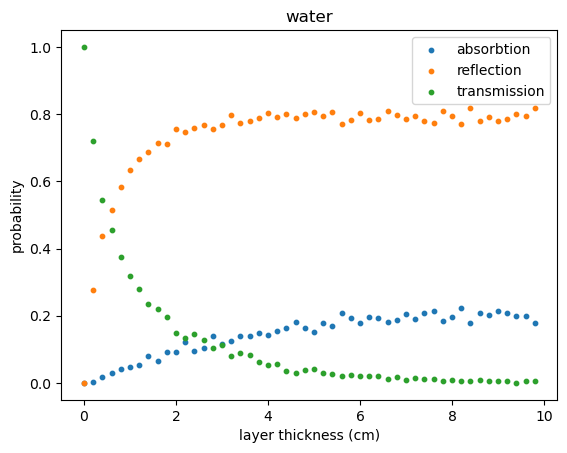

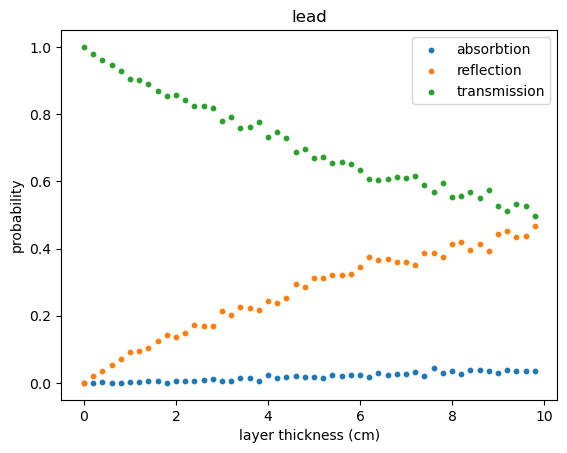

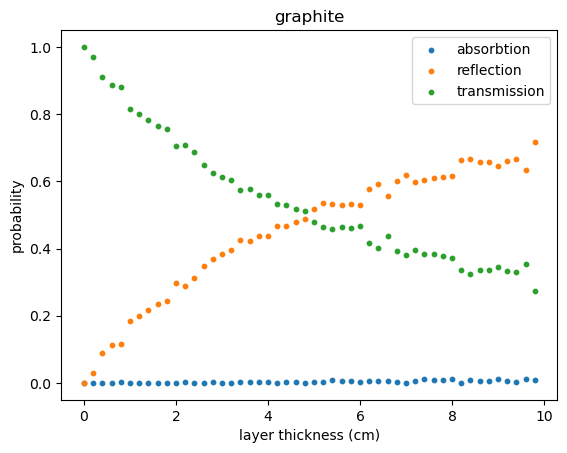

In [23]:
layer_thickness_array = np.arange(0, 10, 0.2)

for i in range(len(mean_free_path)):

    data = np.empty((0, 3))
    
    for j in range(len(layer_thickness_array)):
    
        p = Results(1000, mean_free_path[i], absorbtion_probability_array[i], 
                    layer_thickness=layer_thickness_array[j])

        data = np.vstack((data, p))
    
    plt.scatter(layer_thickness_array, (data[:, 0]), label='absorbtion', s=10)
    plt.scatter(layer_thickness_array, (data[:, 1]), label='reflection', s=10)
    plt.scatter(layer_thickness_array, (data[:, 2]), label='transmission', s=10)
    plt.legend()
    plt.title('{}'.format(names[i]))
    plt.xlabel('layer thickness (cm)')
    plt.ylabel('probability')
    plt.show()

### 4.2 Mean free path calculation

In this section, mean free path for each of the materials is estimated via the method, outlined in section 2.1. Custom parameters are possible.

Enter the number of neutron to simulate (1000 recomended): 100
Enter the number of simulation runs (5 recomended): 5
simulation for water pending
--------------------------
1 out of 5 runs completed
2 out of 5 runs completed
3 out of 5 runs completed
4 out of 5 runs completed
5 out of 5 runs completed


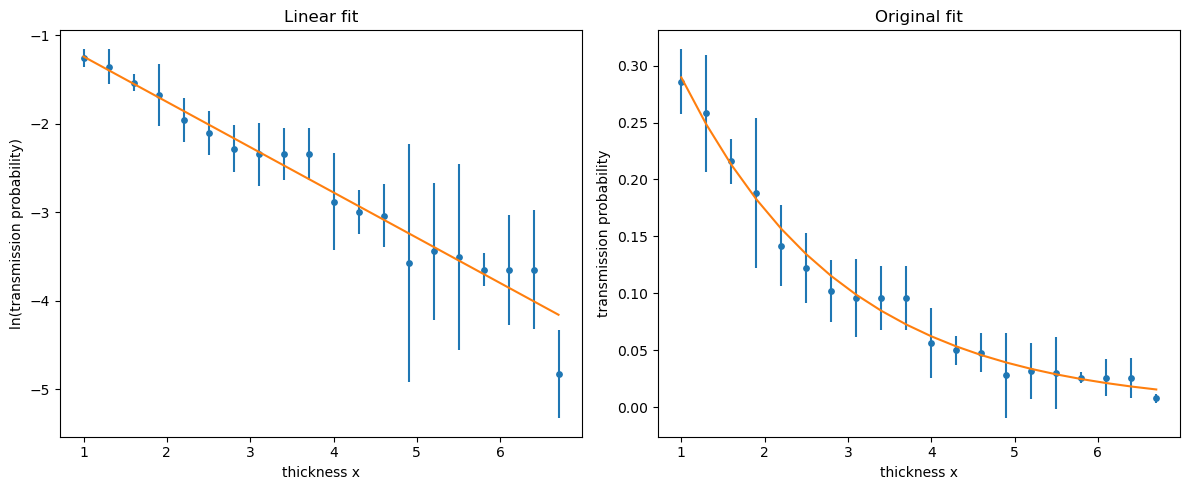

estimated attenuation lenght of neutrons in water is 1.9527 ± 0.0009 cm
--------------------------------------------------------------------
 
simulation for lead pending
--------------------------
1 out of 5 runs completed
2 out of 5 runs completed
3 out of 5 runs completed
4 out of 5 runs completed
5 out of 5 runs completed


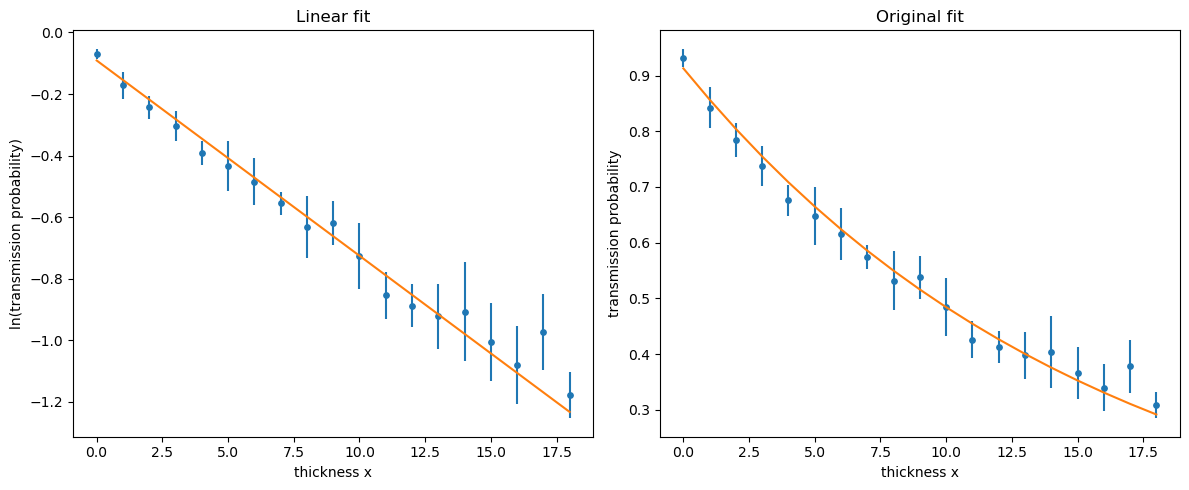

estimated attenuation lenght of neutrons in lead is 15.7729 ± 0.0007 cm
--------------------------------------------------------------------
 
simulation for graphite pending
--------------------------
1 out of 5 runs completed
2 out of 5 runs completed
3 out of 5 runs completed
4 out of 5 runs completed
5 out of 5 runs completed


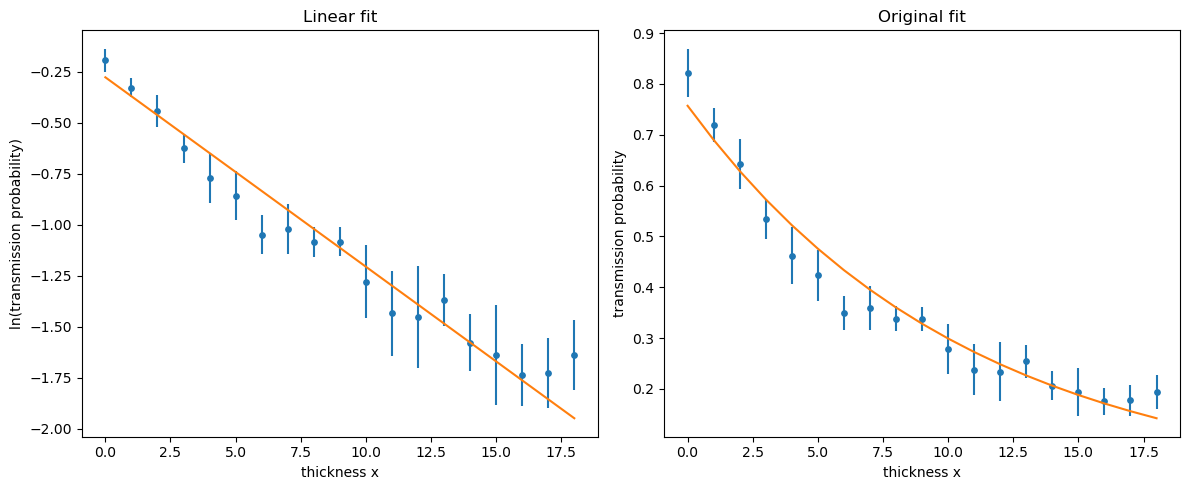

estimated attenuation lenght of neutrons in graphite is 10.7711 ± 0.002 cm
--------------------------------------------------------------------
 


In [24]:
neutron_number = input('Enter the number of neutron to simulate (1000 recomended): ')
simulation_number = input('Enter the number of simulation runs (5 recomended): ')

# For each material, optimal array of thicknesses needed, as they all have different attenuation lengths
three_layer_thickness_arrays = np.array([np.arange(1, 7, 6/20), 
                                         np.arange(0, 20, 20/20), 
                                         np.arange(0, 20, 20/20)])

for (layer_thickness_array, name, l, absorbtion_prob) in zip(three_layer_thickness_arrays, 
                                                             names, 
                                                             mean_free_path, 
                                                             absorbtion_probability_array):
    
    print('simulation for {} pending'.format(name))
    print('--------------------------')
    
    data_array = np.empty((0, len(layer_thickness_array)))

    for i in range(int(simulation_number)):

        data = np.array([])

        for j in range(len(layer_thickness_array)):

            p = Results(int(neutron_number), l, absorbtion_prob, layer_thickness=layer_thickness_array[j], only_transmit=True)

            data = np.append(data, p)

        data_array = np.vstack((data_array, data))
        print('{} out of {} runs completed'.format(i+1, simulation_number))
    
    # calculate statistical parameters
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    
    # exclusde zeroes from the fit
    means = means[np.where(means != 0)]
    stds = stds[np.where(means != 0)]
    layer_thickness_array = layer_thickness_array[np.where(means != 0)]
    
    means = means[np.where(stds != 0)]
    stds = stds[np.where(stds != 0)]
    layer_thickness_array = layer_thickness_array[np.where(stds != 0)]
    

    # make a fit
    coeffs = np.polyfit(layer_thickness_array, np.log(means), 1, w=means/stds, cov=True)
    
    # create a figure
    fig = plt.figure(figsize=(12, 5))

    # first plot
    ax1 = fig.add_subplot(121)
    ax1.errorbar(layer_thickness_array, np.log(means), stds/means, ls='None')
    ax1.scatter(layer_thickness_array, np.log(means), s=15)
    ax1.plot(layer_thickness_array, coeffs[0][0] * layer_thickness_array + coeffs[0][1])

    # fix labels
    ax1.set_title('Linear fit')
    ax1.set_xlabel('thickness x')
    ax1.set_ylabel('ln(transmission probability)')

    # create second plot
    ax2 = fig.add_subplot(122)
    ax2.errorbar(layer_thickness_array, means, stds, ls='None')
    ax2.scatter(layer_thickness_array, means, s=15)
    ax2.plot(layer_thickness_array, np.exp(coeffs[0][1] + layer_thickness_array * coeffs[0][0]))

    # fix labels
    ax2.set_title('Original fit')
    ax2.set_xlabel('thickness x')
    ax2.set_ylabel('transmission probability')

    plt.tight_layout()
    plt.show()
    print('estimated attenuation lenght of neutrons in {} is {:.4f} ± {:.1} cm'
      .format(name, - 1 / coeffs[0][0], coeffs[1][0][0] / coeffs[0][0]**2))
    print('--------------------------------------------------------------------')
    print(' ')

Regardless of ones decided parameters, the results for 5000 neutrons and 20 runs are presented below.

***Water*** 

> 1.8291 ± 0.0003 cm

***Lead***

> 16.1459 ± 0.0004 cm

***Graphite***

> 10.588 ± 0.002 cm

Calculations were completed several times and it became apparent, that errors given by the covariance matrix of the polyfit function are again underestimated. Realistically, uncertainty should be about two orders of magnitude bigger.

## 5. The Woodcock Method

In this section, we are going to explore the penetration of neutrons through the two connected slabs of different materials using the Woodcock method. To implement it, a concept of fictitious step is going to be used. A neutron is making steps distributed according to the least mean free path of two materials. In the material with longer mean free path, a possibility of making a fictitious step is introduced. Such step is completed in the same direction without any possibility of absorption or scattering. 

The probability of undergoing the fictitious step is given by:

$P_f = \frac{\Sigma_T - \Sigma_1}{\Sigma_T}$, where  $\Sigma_T =\Sigma_1 + \Sigma_2 $ and $\Sigma_1$ is the smaller cross-section out of two.


In [25]:
def WoodcockPathRun(sigma1, sigma2, absorb_prob_1, absorb_prob_2, T=10):
    
    # Initialisation 
    absorbed = False
    position = np.array([0., 0., 0.])

    # transmitted neutron counter
    transmitted = 0

    # history tracker
    position_history = np.array([0., 0., 0.])
    
    # initial step direction
    phi = 0
    theta = np.pi/2
    
    while not absorbed:
        
        #print(position)
        step_length = InverseCDF(np.random.uniform(), (1 / np.max([sigma1, sigma2])))
        position_history = np.vstack((position_history, position))

        
        if position[0] >= 0 and position[0] < T:
            # we are in region one with sigma1

            
            ficticious_check = np.random.uniform()
            ficticious_prob = sigma1 / (sigma1 + sigma2)
            
            # fictitious or real step?
            
            if sigma1 < sigma2 and ficticious_check > ficticious_prob:
                # ficticious, keep the same direction

                x = step_length*np.sin(theta)*np.cos(phi)
                y = step_length*np.sin(theta)*np.sin(phi)
                z = step_length*np.cos(theta)
                step = np.array([x, y, z])

                position = position + step
                
            else: 
                # real step, check for absorbtion/scattering

                # choose process
                choice = np.random.uniform()

                if choice < absorb_prob_1:
                    # particle is absorbed
                    absorbed = True
                    
                else:
                    # particle is scattered, choose new direction
                    phi = 2*np.pi*np.random.uniform()
                    theta = np.arccos(1 - 2*np.random.uniform())
                    
                    x = step_length*np.sin(theta)*np.cos(phi)
                    y = step_length*np.sin(theta)*np.sin(phi)
                    z = step_length*np.cos(theta)
                    step = np.array([x, y, z])

                    position = position + step
                    
        elif position[0] >= T and position[0] < 2*T:
            # we are in region two with sigma2

            ficticious_check = np.random.uniform()
            ficticious_prob = sigma2 / (sigma1 + sigma2)
            
            # fictitious or real step?
            
            if sigma2 < sigma1 and ficticious_check > ficticious_prob:
                # ficticious, keep the same direction


                
                x = step_length*np.sin(theta)*np.cos(phi)
                y = step_length*np.sin(theta)*np.sin(phi)
                z = step_length*np.cos(theta)
                step = np.array([x, y, z])

                position = position + step
                
            else: 
                # real step, check for absorbtion/scattering

                # choose process
                choice = np.random.uniform()

                if choice < absorb_prob_2:
                    # particle is absorbed

                    absorbed = True
                    
                else:

                    # particle is scattered, choose new direction
                    phi = 2*np.pi*np.random.uniform()
                    theta = np.arccos(1 - 2*np.random.uniform())
                    
                    x = step_length*np.sin(theta)*np.cos(phi)
                    y = step_length*np.sin(theta)*np.sin(phi)
                    z = step_length*np.cos(theta)
                    step = np.array([x, y, z])

                    position = position + step
            
        elif position[0] < 0:
            # particle is scattered

            break
        
        elif position[0] >= 2*T:

            # particle is transmitted
            transmitted += 1
            break 
            
    return position_history, transmitted

Let's try to visualise a path of a neutron for such arrangement.

<IPython.core.display.Javascript object>


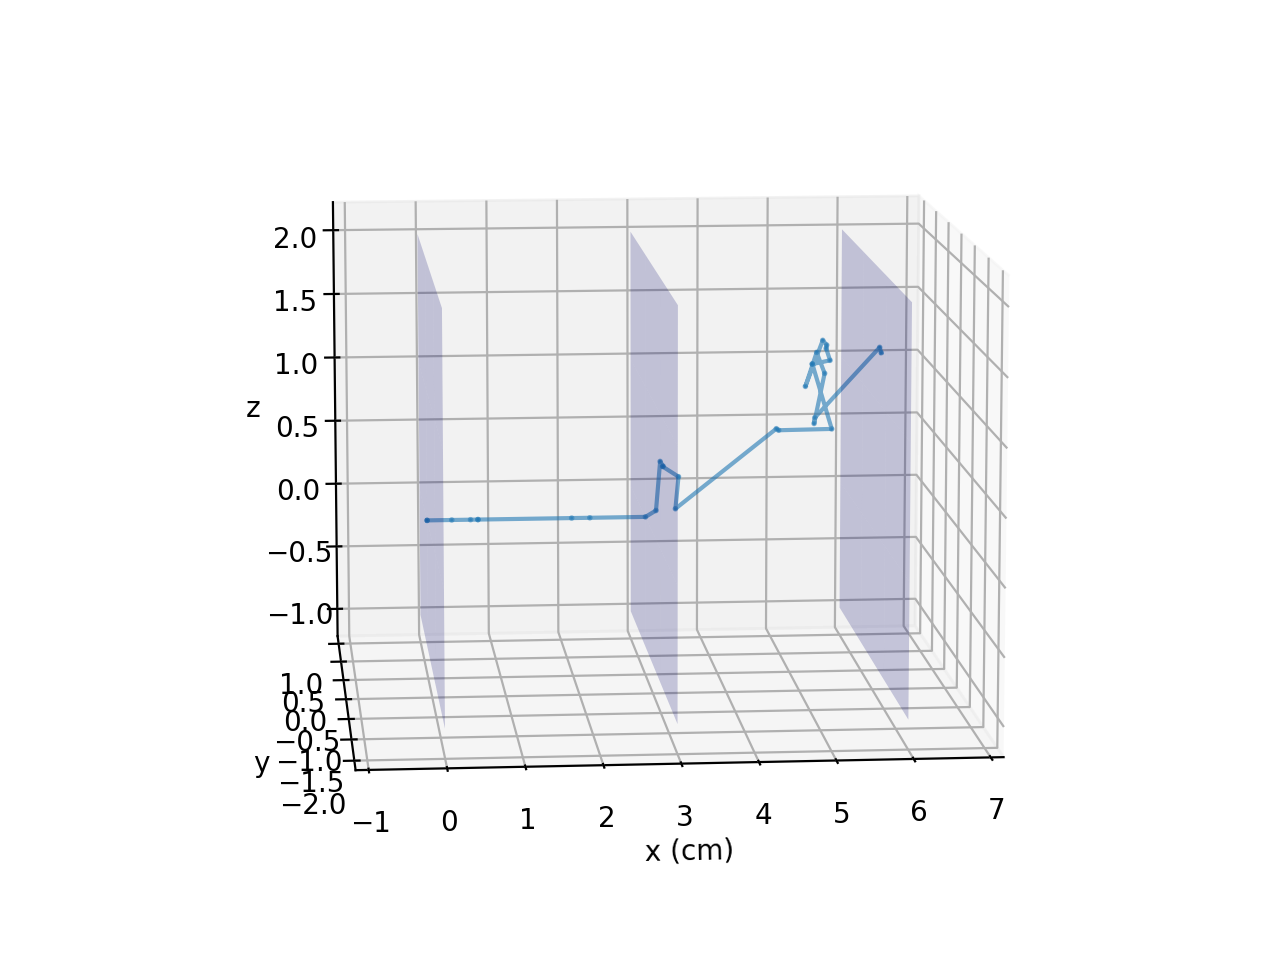

In [140]:
transmitted_total = 0

fig = plt.figure()
ax = Axes3D(fig, azim=90 + 175, elev=10)

position_history, transmitted = WoodcockPathRun(1/mean_free_path[2], 
                                                1/(mean_free_path[0] * 1.5), 
                                                absorbtion_probability_array[2], 
                                                absorbtion_probability_array[0], T=3)

ax.axes.set_xlim3d(left=-1, right=7)
ax.scatter(position_history[:, 0], position_history[:, 1], position_history[:, 2], alpha=0.5, s=1)
ax.plot(position_history[:, 0], position_history[:, 1], position_history[:, 2], alpha=0.6)

# plot the plane
yy, zz = np.meshgrid(range(np.int(np.min(position_history[:, 1])) - 1, 
                           np.int(np.max(position_history[:, 1])) + 2), 
                     range(np.int(np.min(position_history[:, 2])) - 1, 
                           np.int(np.max(position_history[:, 2])) + 2))

ax.plot_surface(6, yy, zz, alpha=0.2, color='blue')
ax.plot_surface(0, yy, zz, alpha=0.2, color='blue')
ax.plot_surface(3, yy, zz, alpha=0.2, color='blue')  

ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Neutron scattering in two different materials')
plt.show()

### Bonus: neutron path simulation animation

A simple animation was created to represent the path of neutrons step by step.

<IPython.core.display.Javascript object>


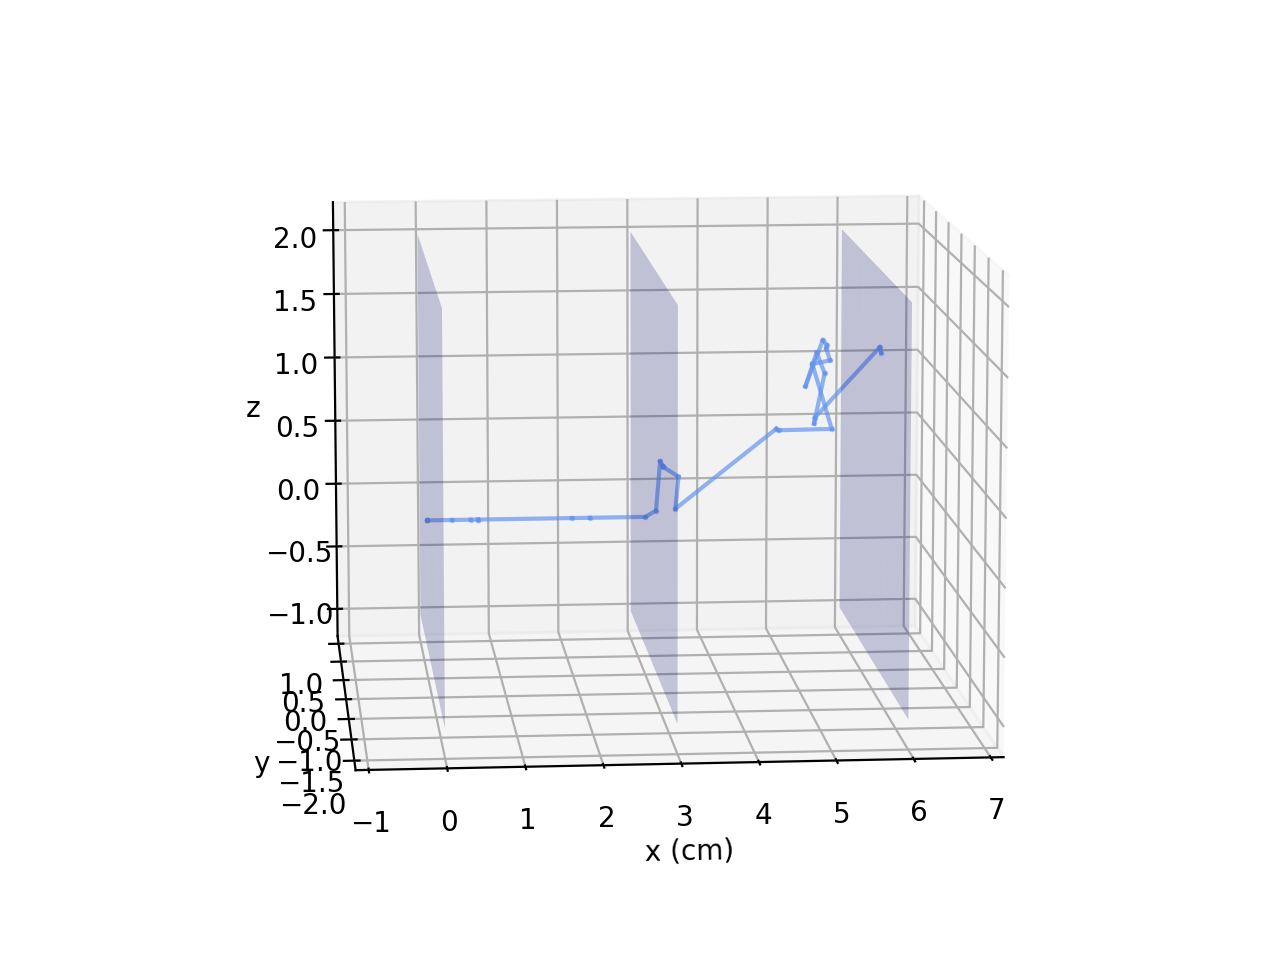

In [144]:
import matplotlib.animation as animation 
# make the plot interactive
get_ipython().magic('matplotlib notebook')

# Create new Figure and an Axes which fills it
fig = plt.figure('Neurton path animation') 
ax = Axes3D(fig, azim=90 + 175, elev=10)
ax.axes.set_xlim3d(left=-1, right=7)


# plot the plane
yy, zz = np.meshgrid(range(np.int(np.min(position_history[:, 1])) - 1, 
                           np.int(np.max(position_history[:, 1])) + 2), 
                     range(np.int(np.min(position_history[:, 2])) - 1, 
                           np.int(np.max(position_history[:, 2])) + 2))

ax.plot_surface(6, yy, zz, alpha=0.2, color='blue')
ax.plot_surface(0, yy, zz, alpha=0.2, color='blue')
ax.plot_surface(3, yy, zz, alpha=0.2, color='blue')  

ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
ax.set_zlabel('z')

# animation function 
def animate(i):  
    
    ax.plot(position_history[i-1:i+1, 0], 
            position_history[i-1:i+1, 1], 
            position_history[i-1:i+1, 2], alpha=0.7, color='cornflowerblue')
    
    ax.scatter(position_history[i, 0], 
           position_history[i, 1], 
           position_history[i, 2], alpha=0.5, s=1, color='cornflowerblue')

# call the animator 
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(position_history[:, 0]), blit=True)

### 5.1 fraction of transmitted neutrons

Here, the percentage of transmitted neutrons is calculated for 10 cm of graphite and 10 cm of lead.

In [91]:
total_neutron_number = 1000

transmitted_total = 0

for i in range(total_neutron_number):

    position_history, transmitted = WoodcockPathRun(1/mean_free_path[2], 
                                                    1/(mean_free_path[1]), 
                                                    absorbtion_probability_array[2], 
                                                    absorbtion_probability_array[1], T=10)
    transmitted_total += transmitted

print('For this arrangement {:.1f} % of nutrons are transmitted'
      .format(transmitted_total/total_neutron_number * 100))

For this arrangement 6.5 % of nutrons are transmitted


But one can choose their own materials and simulation precision if needed.

In [103]:
total_neutron_number = input('Enter the number of neutrons: ')
thickness = input('Enter thicknness of a single slab in cm: ')
print(' ')
print('Known mean free paths in cm:')
print('water: 0.2886 cm')
print('lead: 5.8531 cm')
print('graphite: 2.5172 cm')
print(' ')
mean_free_path_1 = input('Enter mean free path of the first material: ')
mean_free_path_2 =input('Enter mean free path of the second material: ')
print(' ')
print('Known absorbtion probabilities:')
print('water: 0.00642')
print('lead: 0.01389')
print('graphite: 0.0009485')
print(' ')
absorbtion_probability_1 = input('Enter absorbtion probability for the first material: ')
absorbtion_probability_2 = input('Enter absorbtion probability for the second material: ')

for i in range(np.int(total_neutron_number)):

    position_history, transmitted = WoodcockPathRun(1/np.float(mean_free_path_1), 
                                                    1/np.float(mean_free_path_2), 
                                                    absorbtion_probability_array[2], 
                                                    absorbtion_probability_array[1], T=np.float(thickness))
    transmitted_total += transmitted

print(' ')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ')
print('For this arrangement {:.1f} % of nutrons are transmitted'
      .format(transmitted_total/np.int(total_neutron_number) * 100))

Enter the number of neutrons: 1000
Enter thicknness of a single slab in cm: 3
 
Known mean free paths in cm:
water: 0.2886 cm
lead: 5.8531 cm
graphite: 2.5172 cm
 
Enter mean free path of the first material: 5.8531
Enter mean free path of the second material: 2.5172
 
Known absorbtion probabilities:
water: 0.00642
lead: 0.01389
graphite: 0.0009485
 
Enter absorbtion probability for the first material: 0.01389
Enter absorbtion probability for the second material: 0.0009485
 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
For this arrangement 57.7 % of nutrons are transmitted


To check if the simulation works correctly, the percentage of transmitted neutrons is calculated for 10 cm of (almost) vacuum and 10 cm of graphite.

In [107]:
total_neutron_number = 1000
transmitted_total = 0

for i in range(total_neutron_number):

    position_history, transmitted = WoodcockPathRun(1e-10, 
                                                    1/(mean_free_path[2]), 
                                                    0, 
                                                    absorbtion_probability_array[2], T=10)
    transmitted_total += transmitted

print('For this arrangement {:.1f} % of nutrons are transmitted'.format(transmitted_total/total_neutron_number * 100))

For this arrangement 32.3 % of nutrons are transmitted


It can be seen that 30% is similar result to the previous calculation done in section 3.3 using another method. So, we can conclude that this simulation is working correctly.